In [ ]:
import os
import random
import itertools
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import pathlib

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
print(tf.__version__)

2.8.2


In [ ]:
dataset_url = "https://storage.googleapis.com/data-science-tools-2/train-filtered.zip"
data_dir = tf.keras.utils.get_file('train-filtered', origin=dataset_url, untar=True, archive_format='zip')
data_dir = pathlib.Path(data_dir)
print(data_dir)

11410636800/11410623393 [==============================] - 178s 0us/step
/root/.keras/datasets/train-filtered


In [ ]:
test_url = "https://storage.googleapis.com/data-science-tools-2/test-rename.zip"
test_dir = tf.keras.utils.get_file('test-rename', origin=test_url, untar=True, extract=True, archive_format='zip')
test_dir = pathlib.Path(test_dir)
print(test_dir)

3669917696/3669909249 [==============================] - 59s 0us/step
/root/.keras/datasets/test-rename


In [ ]:
# labels = folder names
!ls /root/.keras/datasets/

test-rename.tar.gz  train-filtered.tar.gz


In [ ]:
 %cd /root/.keras/datasets/
 !unzip test-rename.tar.gz
 !unzip train-filtered.tar.gz

Streaming output truncated to the last 5000 lines.
  inflating: train-filtered/flooding/trainval_flooding_img_2858.jpg  
  inflating: __MACOSX/train-filtered/flooding/._trainval_flooding_img_2858.jpg  
  inflating: train-filtered/flooding/trainval_flooding_img_1389.jpg  
  inflating: __MACOSX/train-filtered/flooding/._trainval_flooding_img_1389.jpg  
  inflating: train-filtered/flooding/trainval_flooding_img_2694.jpg  
  inflating: __MACOSX/train-filtered/flooding/._trainval_flooding_img_2694.jpg  
  inflating: train-filtered/flooding/trainval_flooding_img_1174.jpg  
  inflating: __MACOSX/train-filtered/flooding/._trainval_flooding_img_1174.jpg  
  inflating: train-filtered/flooding/trainval_flooding_img_700.jpg  
  inflating: __MACOSX/train-filtered/flooding/._trainval_flooding_img_700.jpg  
  inflating: train-filtered/flooding/trainval_flooding_img_3005.jpg  
  inflating: __MACOSX/train-filtered/flooding/._trainval_flooding_img_3005.jpg  
  inflating: train-filtered/flooding/trainval

In [ ]:
!ls /root/.keras/datasets/test-rename

sub


In [ ]:
!ls /root/.keras/datasets/train-filtered

canal	  flooding  road      sewer	stray
electric  light     sanitary  sidewalk	traffic


In [ ]:
class_names = ['flooding', 'electric', 'canal', 'stray', 'light', 'traffic', 'road', 'sidewalk', 'sanitary', 'sewer']

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
test_image_count = len(list(test_dir.glob('*/*.jpg')))
print(test_image_count)

20876
6425


In [ ]:
# flooding = list(data_dir.glob('flooding/*'))
# print(str(flooding[0]))
# PIL.Image.open(str(flooding[0]))

## Create data set

In [ ]:
image_size = 300
num_class = 10
batch_size = 16

#image augmentation
train_datagen = ImageDataGenerator(
        rescale=1.0/255.0, 
        shear_range = 0.2,
        zoom_range = 0.2,
        fill_mode="nearest",
        validation_split=0.2,
        vertical_flip=False,
        horizontal_flip=True)
 
validation_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

#create train and validation 
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size,
        seed=123,
        subset="training",
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        data_dir,
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size,
        seed=123,
        subset="validation",
        class_mode='categorical')

Found 16706 images belonging to 10 classes.
Found 4170 images belonging to 10 classes.


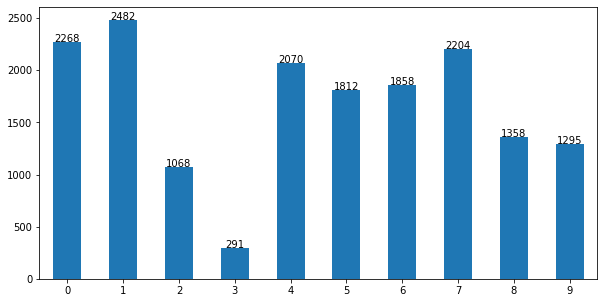

In [ ]:
#train statistics
y_train = train_generator.labels
df_train = pd.DataFrame(y_train, columns=['class'])
ax = df_train['class'].value_counts().sort_index(na_position='first').plot(kind='bar', rot=0, figsize=(10,5), sort_columns=True)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height+4, '{:1.0f}'.format(height), ha="center")

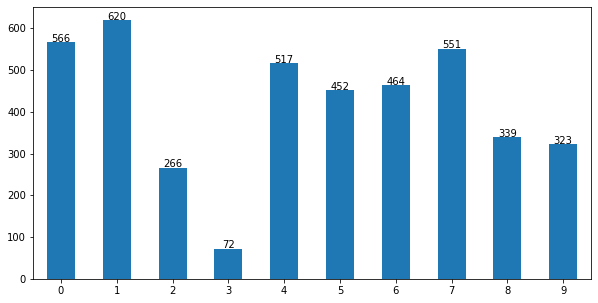

In [ ]:
#validation statistics
y_val = validation_generator.labels
df_val = pd.DataFrame(y_val, columns=['class'])
ax = df_val['class'].value_counts().sort_index(na_position='first').plot(kind='bar', rot=0, figsize=(10,5), sort_columns=True)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height+1.5, '{:1.0f}'.format(height), ha="center")

## visualize image

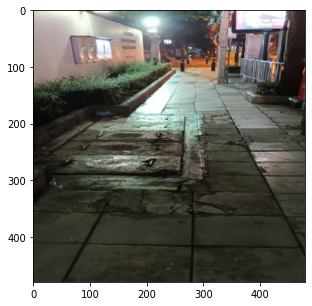

In [ ]:
#visualize image from train set

x, y = train_generator.next() # x=image, y=label
i = random.randint(0, batch_size-1)
plt.subplots(1, 1, figsize=(10,5))
plt.imshow(x[i])

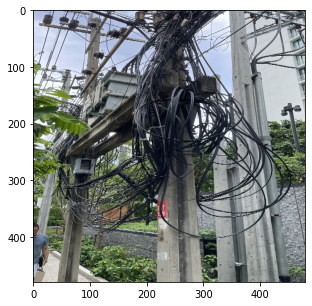

In [ ]:
#visualize image from validation set

x, y = validation_generator.next()
i = random.randint(0, batch_size-1)
plt.subplots(1, 1, figsize=(10,5))
plt.imshow(x[i])

## training

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M

efnv2m = EfficientNetV2M(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
)

for layer in efnv2m.layers:
  layer.trainable = True

model2 = Sequential()
model2.add(efnv2m)
model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten_5 (Flatten)         (None, 128000)            0         
                                                                 
 dropout_12 (Dropout)        (None, 128000)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               32768256  
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                2570      
                                                      

In [ ]:
epochs=20
callbacks = [
               ModelCheckpoint('efnv2m_best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1),
               ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=3, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)
               ]

history = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
    )

Epoch 1/20
1045/1045 [==============================] - ETA: 0s - loss: 1.1799 - accuracy: 0.6238
Epoch 1: val_accuracy improved from -inf to 0.67530, saving model to efnv2m_best_model.h5
1045/1045 [==============================] - 1040s 967ms/step - loss: 1.1799 - accuracy: 0.6238 - val_loss: 1.0235 - val_accuracy: 0.6753 - lr: 1.0000e-04
Epoch 2/20
1045/1045 [==============================] - ETA: 0s - loss: 0.7908 - accuracy: 0.7560
Epoch 2: val_accuracy did not improve from 0.67530
1045/1045 [==============================] - 987s 943ms/step - loss: 0.7908 - accuracy: 0.7560 - val_loss: 1.1737 - val_accuracy: 0.6568 - lr: 1.0000e-04
Epoch 3/20
1045/1045 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.8044
Epoch 3: val_accuracy improved from 0.67530 to 0.68489, saving model to efnv2m_best_model.h5
1045/1045 [==============================] - 955s 914ms/step - loss: 0.6401 - accuracy: 0.8044 - val_loss: 1.1316 - val_accuracy: 0.6849 - lr: 1.0000e-04
Epoch 4/2

## Test Prediction

In [ ]:
#create test set
print(test_dir)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=1,
        shuffle= False,
        class_mode=None)

/root/.keras/datasets/test-rename
Found 6425 images belonging to 1 classes.


In [ ]:
#predict values from test set
y_pred = model2.predict(test_generator, steps = len(test_generator))
#convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
y_pred_classes_series = pd.Series(y_pred_classes)
y_pred_classes_series.to_csv("test-result.csv")

In [ ]:
from google.colab import files
files.download('test-result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from google.colab import files
# files.download('efnv2m_best_model.h5')

In [ ]:
model2.save_weights('efnv2m_w_best.h5')
files.download('efnv2m_w_best.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('efnv2m_best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualize training results

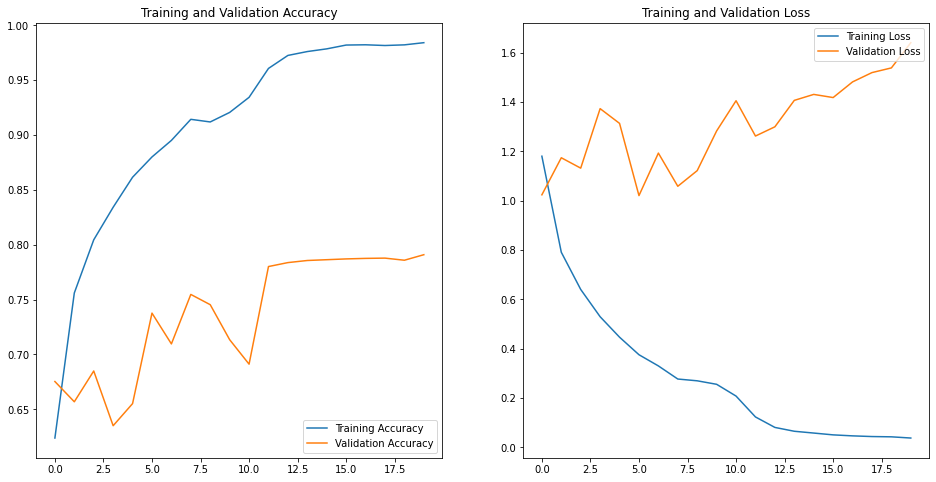

In [ ]:
# history = history2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()